# Notebook for BNN and XNOR-Net Training
Using Kannada MNIST Dataset

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
from CustomOps.customOps import SetSession

# Call this first here, to make sure that Tensorflow registers our custom ops properly
# SetSession()

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from CompositeLayers.ConvBNReluLayer import ConvBNReluLayer
from CompositeLayers.BinaryNetConvBNReluLayer import BinaryNetConvBNReluLayer, BinaryNetActivation
from CustomLayers.CustomLayersDictionary import customLayersDictionary
from CompositeLayers.XNORConvLayer import XNORConvBNReluLayer, BNXNORConvReluLayer
from NetworkParameters import NetworkParameters
from CustomLayers.CustomLayersDictionary import customLayerCallbacks

np.random.seed(198)

Using TensorFlow backend.


# Create model

In [18]:
# Binarized convolution neural network
def Create_BNN(input_shape, nb_classes, binarisation_type):
    model_input = Input(shape=input_shape)

    output = model_input

    if binarisation_type == 'BinaryNet':
        print('Using BinaryNet binary convolution layers')
        layerType = BinaryNetConvBNReluLayer
    elif binarisation_type == 'XNORNet':
        print('Using XNORNet binary convolution layers')
        layerType = BNXNORConvReluLayer
    else:
        assert False, 'Unsupported binarisation type!'

    # As per the paper, the first layer can't be binary
    output = ConvBNReluLayer(input=output, nb_filters=8, border='valid', kernel_size=(3, 3), stride=(1, 1))

    output = layerType(input=output, nb_filters=16, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = layerType(input=output, nb_filters=16, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = MaxPooling2D((2, 2))(output)
    output = layerType(input=output, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = layerType(input=output, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = MaxPooling2D((2, 2))(output)
    output = Flatten()(output)
    output = Dense(nb_classes, use_bias=True, activation='softmax')(output)

    model = Model(inputs=model_input, outputs=output, name=binarisation_type)

    model.summary()

    return model

# Data Preparation

In [2]:
data = pd.read_csv("../input/kan_mnist.csv")
classname = [str(n) for n in data.label.unique()]

X, y = [],[]
for i in range(len(data)):
    re_X, re_y = data.iloc[i, 1:].values.reshape(28,28), data.iloc[i].label   
    X.append(np.array(re_X))
    y.append(np.array(re_y))
    
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

# data split
X_train, y_train = X[:50000], y[:50000] 
X_test, y_test = X[50000:], y[50000:] 

if len(X_train.shape) < 4:
    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)

input_shape = X_train.shape[1:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0

nb_classes = y_train.max()+1

# label to categorical 
y_test_cat = to_categorical(y_test, nb_classes)
y_train_cat = to_categorical(y_train, nb_classes)

(60000, 28, 28) (60000,)


# Parameters

In [8]:
modelDirectory = os.getcwd()

parameters = NetworkParameters(modelDirectory)
parameters.nb_epochs = 5
parameters.batch_size = 32
parameters.lr = 0.0005
parameters.batch_scale_factor = 8
parameters.decay = 0.001

# parameters.binarisation_type = 'XNORNet' # Either 'BinaryNet' or 'XNORNet'

parameters.lr *= parameters.batch_scale_factor
parameters.batch_size *= parameters.batch_scale_factor

print('Learning rate is: %f' % parameters.lr)
print('Batch size is: %d' % parameters.batch_size)

optimiser = Adam(lr=parameters.lr, decay=parameters.decay)

Learning rate is: 0.004000
Batch size is: 256


# XNOR-Net

# _

# Build model

In [19]:
xnor_model = Create_BNN(input_shape=input_shape, nb_classes=nb_classes, binarisation_type='XNORNet')

xnor_model.compile(loss='categorical_crossentropy',
              optimizer=optimiser,
              metrics=['accuracy'])

Using XNORNet binary convolution layers
Model: "XNORNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_36 (Batc (None, 26, 26, 8)         32        
_________________________________________________________________
activation_36 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 26, 26, 8)         32        
_________________________________________________________________
xnor_net_conv2d_30 (XNORNetC (None, 24, 24, 16)        1161      
_________________________________________________________________
activation_37 (Acti

In [6]:
# plot_model(xnor_model, to_file=os.path.join(os.getcwd(), 'results/arch/xnor_arch.png'),
#                                   show_shapes=True, show_layer_names=False)

# Training

In [20]:
xnor_history = xnor_model.fit(x=X_train,
          y=y_train_cat,
          batch_size=parameters.batch_size,
          epochs=parameters.nb_epochs,
          callbacks=customLayerCallbacks,
          validation_data=(X_test, y_test_cat),
          shuffle=True,
          verbose=1
          )

Epoch 1/5
196/196 [==============================] - 27s 140ms/step - loss: 0.4130 - accuracy: 0.8621 - val_loss: 2.4198 - val_accuracy: 0.2660
Epoch 2/5
196/196 [==============================] - 27s 138ms/step - loss: 0.1447 - accuracy: 0.9541 - val_loss: 1.0861 - val_accuracy: 0.6261
Epoch 3/5
196/196 [==============================] - 27s 139ms/step - loss: 0.1276 - accuracy: 0.9599 - val_loss: 0.1667 - val_accuracy: 0.9485
Epoch 4/5
196/196 [==============================] - 27s 139ms/step - loss: 0.1070 - accuracy: 0.9667 - val_loss: 0.1466 - val_accuracy: 0.9553
Epoch 5/5
196/196 [==============================] - 27s 139ms/step - loss: 0.0842 - accuracy: 0.9740 - val_loss: 0.0589 - val_accuracy: 0.9807


# Evaluation

In [7]:
def plot_training(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    plt.title("CNN")
    ax1.plot(history.history['loss'], color='b', label="Training loss", linewidth=2)
    ax1.plot(history.history['val_loss'], color='r', label="validation loss", linewidth=2)
    ax1.set_xticks(np.arange(0, parameters.nb_epochs, 1))
    ax1.title.set_text("Loss (Training: "+str(round(history.history['loss'][-1],4))+", Validation: "+str(round(history.history['val_loss'][-1],4))+")")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc='best', shadow=False)

    ax2.plot(history.history['acc'], color='b', label="Training accuracy", linewidth=2)
    ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy", linewidth=2)
    ax2.set_xticks(np.arange(0, parameters.nb_epochs, 1))
    ax2.title.set_text("Accuracy (Training: "+str(round(history.history['acc'][-1]*100,2))+"%, Validation: "+str(round(history.history['val_acc'][-1]*100,2))+"%)")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='lower right', shadow=False)
    plt.rcParams.update({'font.size': 10})
    
    plt.tight_layout()
    plt.savefig('results/xnor_train_plot.png', bbox_inches='tight', dpi=200)
    plt.show()

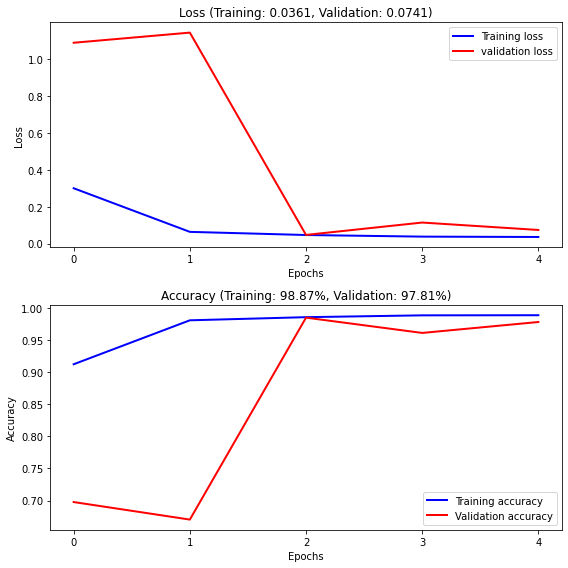

In [8]:
plot_training(xnor_history)

### Save model

In [21]:
xnor_model.save('saved_models/xnor_lite_model.h5')

### Load model

In [22]:
xnorTest = load_model(filepath='saved_models/xnor_lite_model.h5', custom_objects=customLayersDictionary)

In [11]:
validationAccuracy = xnorTest.evaluate(X_test, y_test_cat, verbose=1)
print('\nBest Keras validation accuracy is : %f \n' % (100.0 * validationAccuracy[1]))


Best Keras validation accuracy is : 97.810000 



In [14]:
pred = xnorTest.predict(X_test)

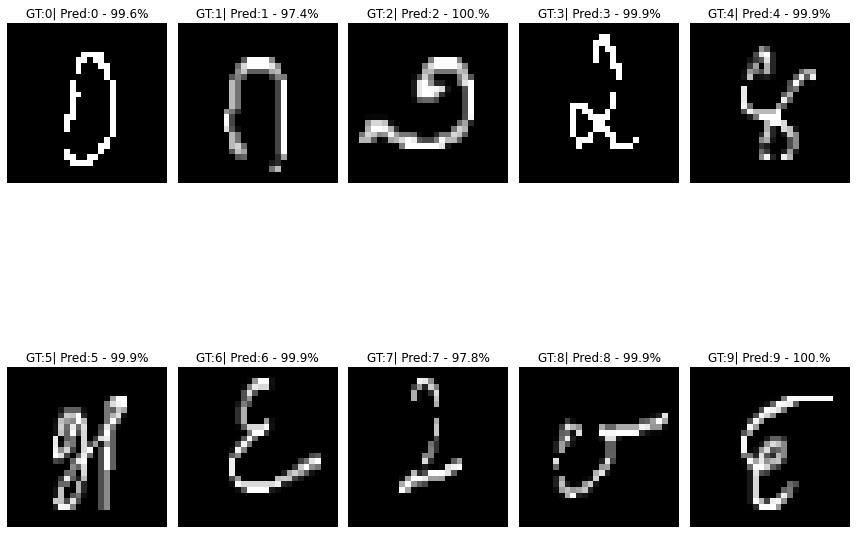

In [30]:
fig, axes = plt.subplots(2, 5, figsize=(12,12))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X_test[i], cmap=plt.get_cmap('gray'))
    ind = np.argmax(pred[i])
    ax.set_title(f"GT:{np.argmax(y_test_cat[i])}| Pred:{ind} - {str(np.max(pred[ind])*100)[:4]}%")
    ax.axis("off")
    
plt.tight_layout()
plt.savefig('results/xnor_pred.jpg',dpi=300)
plt.show()

# Confusion matrix 

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Test Dataset',
                          cmap=plt.cm.Blues,
                          save=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classname)
    plt.yticks(tick_marks, classname)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.tight_layout()
    sh = plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.colorbar(sh,fraction=0.046)
    if save!=0:
      plt.savefig(save+'_cm.jpg',dpi=300)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.94      1.00      0.97      1000
           2       0.99      0.99      0.99      1000
           3       0.99      0.96      0.98      1000
           4       0.99      0.99      0.99      1000
           5       0.98      0.97      0.97      1000
           6       0.98      0.95      0.97      1000
           7       0.95      0.98      0.97      1000
           8       1.00      1.00      1.00      1000
           9       1.00      0.95      0.97      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



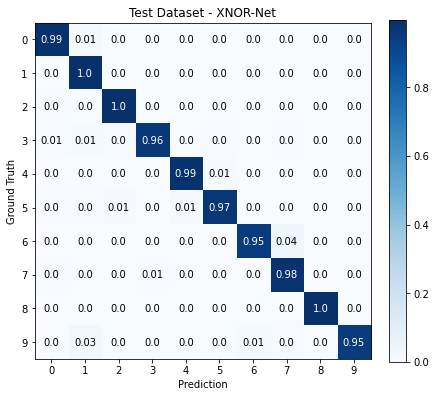

In [15]:
X_train_pred = np.argmax(pred,axis=1)
X_train_true = np.argmax(y_test_cat,axis=1)

f1_report = classification_report(X_train_true, X_train_pred, target_names=classname)
print(f1_report)
with open("results/xnor_f1_report.txt", "w") as f:
    f.write(f1_report)

train_confusion_mtx = confusion_matrix(X_train_true, X_train_pred) 
# plot the confusion matrix
plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)),title="Test Dataset - XNOR-Net", save='results/xnor') 
# plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)), save='output/latest_distress_v2_cnn_P92') 


# **********************************

# TF Lite

## Export our model for tflite

We need to convert our model into a tflite model

In [23]:
import tensorflow as tf
images = tf.cast(X_test, tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(1):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(xnorTest)
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS, # enable TensorFlow ops.
  tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]
print("data")
# converter.representative_dataset = representative_data_gen
tflite_quant_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

data


Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.Use '@tf.function' or '@defun' to decorate the function.

32960

## To convert to C++
We can then run this command to convert the model to c code.
```
xxd -i converted_model.tflite > model_data.cc
```

In [24]:
!xxd -i converted_model.tflite > model_data.cc

In [4]:
type(X_test)

numpy.ndarray